# Importing the necessary libraries and loading the malaria dataset from TFDS

Since there is only a training set available (from documentation provided with dataset), I decided to shuffle the data and split it into training, validation & testing sets from the start. 



In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import matplotlib.pyplot as plt

[train_ds, valid_ds, test_ds] , info = tfds.load("malaria", 
                                                 split = ['train[:70%]', 'train[70%:85%]', 'train[85%:]'], 
                                                 shuffle_files=True, 
                                                 with_info=True)

# Exploring the data



*   Looking at the structure of the dataset which shows that images are not a consistent size
*   Display the number of training samples provided in the overall dataset


*   Display the number of classes in the dataset
*   Dispaly the labels of the classes in the dataset




In [ ]:
print("Training Dataset structure --> " + str(train_ds))
print("Dataset Info --> " + str(info))
print ("******************************************\n")

ds_size = info.splits["train"].num_examples
ds_names = info.features["label"].names
ds_classes = info.features["label"].num_classes

print ("******************************************\n")
print ("Num of training samples: " + str(ds_size))
print ("Classes: " + str(ds_names))
print ("Num of Classes: " + str(ds_classes))

Training Dataset structure --> <_OptionsDataset shapes: {image: (None, None, 3), label: ()}, types: {image: tf.uint8, label: tf.int64}>
Dataset Info --> tfds.core.DatasetInfo(
    name='malaria',
    version=1.0.0,
    description='The Malaria dataset contains a total of 27,558 cell images
with equal instances of parasitized and uninfected cells from the thin blood 
smear slide images of segmented cells.',
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=27558,
    splits={
        'train': 27558,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward 
      improved malaria parasite detection in thin blood smear images},
      author={Rajaraman, Sivaramakrishnan and

Display a few samples just to make sure that they are all different sizes which checks out

In [ ]:
for ex in train_ds.take(5):
    print (ex)

{'image': <tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, 'label': <tf.Tensor: shape=(), dtype=int64, numpy=1>}
{'image': <tf.Tensor: shape=(106, 121, 3), dtype=uint8, numpy=
array([[[0, 0, 0],

Using the provided show_examples method by tfds to see a few of the images with their labels & values

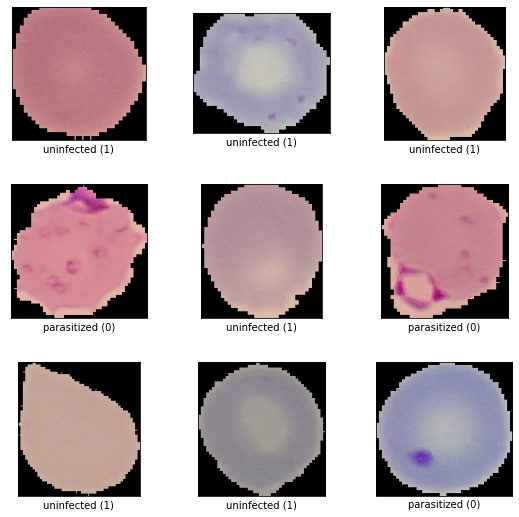

In [ ]:
disp = tfds.show_examples(train_ds, ds_info=info)

# Setting the global variables that will be used throughout the model


In [ ]:
NEW_HEIGHT = 200
NEW_WIDTH = 200
BATCH_SIZE = 32
epochs = 20

A function to resize the images to a consistent size that can be used by the model

In [ ]:
def fix_image(ds):
  ds["image"] = tf.image.convert_image_dtype(ds["image"], tf.float32)
  ds["image"] = tf.image.resize_with_crop_or_pad(ds["image"], NEW_HEIGHT, NEW_WIDTH)
  return ds["image"], ds["label"];

Resizing the 3 datasets that will be used to train, validate and test our model

In [ ]:
fixed_train_ds = train_ds.map(fix_image).batch(BATCH_SIZE)
fixed_valid_ds = valid_ds.map(fix_image).batch(BATCH_SIZE)
fixed_test_ds = test_ds.map(fix_image).batch(BATCH_SIZE)

Displaying some of the converted images to see that their size is consistent and that we didn't damage the data in any way

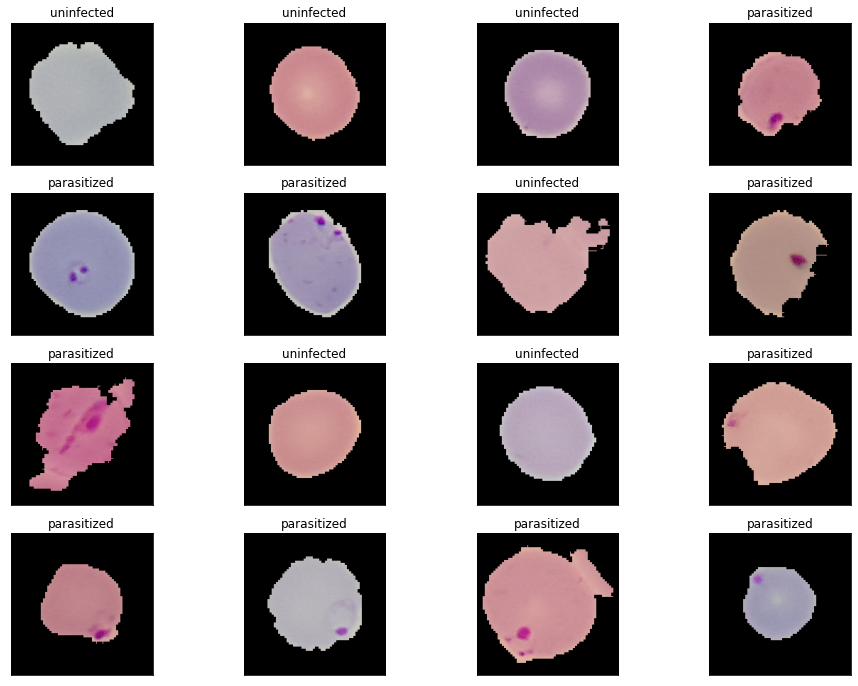

In [ ]:
batch_image, batch_label = next(iter(fixed_train_ds))

plt.figure(figsize= (16,12))

for i in range(16):
    ax = plt.subplot(4,4,i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(batch_image[i])
    if batch_label[i]:
        plt.title(ds_names[1])
    else:
        plt.title(ds_names[0])

# Building the model
- Create the input layer
- Create the convolutional/Pooling layers
  * They will half the filters at every layer the convulational layers increas
  * The minimum # of filters will be 2 if there are too many layers
- Falttening the layers so we can send them to the Dense layers
- Create the dense layers
  * A BatchNormalization Layer
  * A Dense Layer
  * A Dropout Layer
- Final Dense layer with 1 unit

In [ ]:
def build_model (n_hidden=1, n_neurons=256, dropout=0.25, input_shape=[NEW_HEIGHT, NEW_WIDTH, 3]):
    orig_neurons = n_neurons
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Conv2D(n_neurons,3, activation='relu'))
        model.add(keras.layers.MaxPooling2D(2,2))
        n_neurons = n_neurons/2
        if (n_neurons < 2):
            n_neurons = 2
    n_neurons = orig_neurons
    model.add(keras.layers.Flatten())
    for layer in range(n_hidden):
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Dense(n_neurons, activation='relu'))
        model.add(keras.layers.Dropout(dropout))
    model.add(keras.layers.Dense(1, activation="sigmoid"))
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[tf.metrics.AUC(), "accuracy"])
    return model

#Training the Model

Creating 2 callbacks to save the best model and to stop training if its stop improving after 5 epochs

In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("malaria_tfds.h5", save_best_only=True)

earlystop_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

model = build_model(n_hidden=4)
history = model.fit(fixed_train_ds, epochs=epochs, validation_data=fixed_valid_ds,  callbacks=[checkpoint_cb, earlystop_cb])

Epoch 1/20
603/603 [==============================] - 116s 173ms/step - loss: 0.7193 - auc: 0.6174 - accuracy: 0.5863 - val_loss: 1.3781 - val_auc: 0.9586 - val_accuracy: 0.5040
Epoch 2/20
603/603 [==============================] - 98s 162ms/step - loss: 0.2323 - auc: 0.9615 - accuracy: 0.9207 - val_loss: 0.2054 - val_auc: 0.9793 - val_accuracy: 0.9376
Epoch 3/20
603/603 [==============================] - 97s 161ms/step - loss: 0.1853 - auc: 0.9731 - accuracy: 0.9401 - val_loss: 0.1641 - val_auc: 0.9783 - val_accuracy: 0.9444
Epoch 4/20
603/603 [==============================] - 97s 161ms/step - loss: 0.1704 - auc: 0.9774 - accuracy: 0.9478 - val_loss: 0.1553 - val_auc: 0.9814 - val_accuracy: 0.9497
Epoch 5/20
603/603 [==============================] - 97s 161ms/step - loss: 0.1593 - auc: 0.9803 - accuracy: 0.9524 - val_loss: 0.1367 - val_auc: 0.9873 - val_accuracy: 0.9533
Epoch 6/20
603/603 [==============================] - 97s 161ms/step - loss: 0.1519 - auc: 0.9816 - accuracy: 0.95

# Evaluating the model against the Test set

In [ ]:
model.evaluate(fixed_test_ds)

130/130 [==============================] - 7s 49ms/step - loss: 0.1522 - auc: 0.9832 - accuracy: 0.9540


[0.15223313868045807, 0.9832191467285156, 0.9540396928787231]

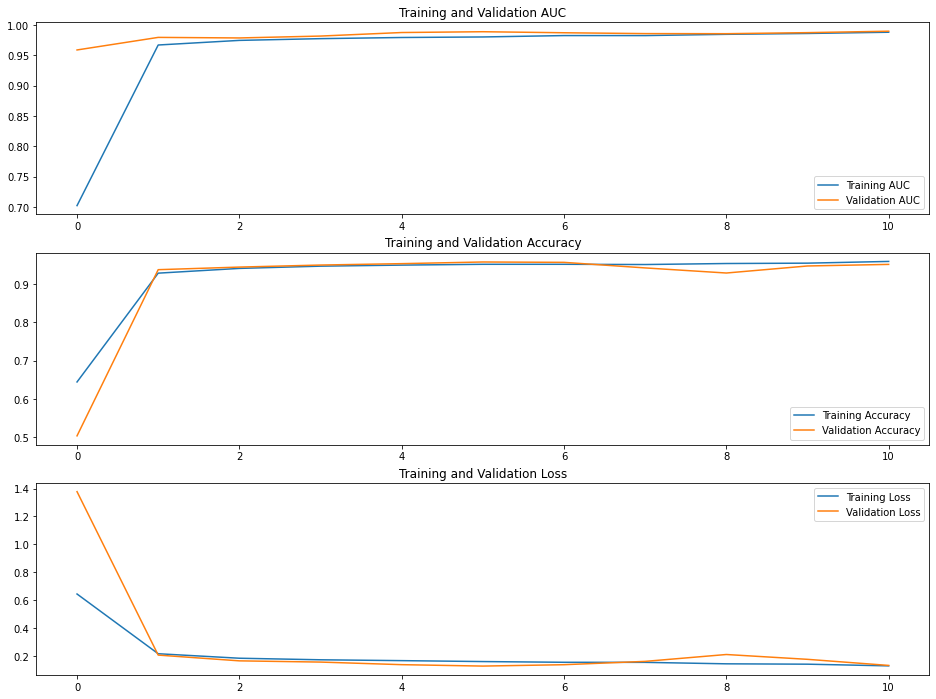

In [ ]:
auc = history.history["auc"]
val_auc = history.history["val_auc"]

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history["auc"]))

plt.figure(figsize=(16, 12))
plt.subplot(3, 1, 1)
plt.plot(epochs_range, auc, label='Training AUC')
plt.plot(epochs_range, val_auc, label='Validation AUC')
plt.legend(loc='lower right')
plt.title('Training and Validation AUC')

plt.subplot(3, 1, 2)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(3, 1, 3)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#Conclusion

* AUC is typically a better metric for logistic regression problems since the data could be skeweed towards one class due to natural occurence but the documentation provided in this dataset showed that both classes were equally represented so I decided to include accuracy also and let the numbers speak for themselves
* Regardless of which metric you use have a 95%+ AUC/Accurray would typically hint at some kind of overfitting but in this case I think the "clean" data played a major role in the outcome.  In real life you probably wouldn't get such a clean labelled data.